In [1]:
import sys
import torch
from torch import nn, optim
import torchvision
from matplotlib import pyplot as plt

sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample")

from src.network import LikApprox
from src.network import PredictApprox
from src.weight_distribution.Diagonal import Diagonal
from src.weight_distribution.Full import FullCovariance
from src.network.Classification import LLVIClassification

sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI")
from BNN_Comparison.TyXe import tyxe
from pyro import distributions as pyro_dist
import pyro
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 14,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
%matplotlib inline
from datetime import datetime
import pandas as pd
import math

In [2]:
batch_size_train = 32
filepath = "/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/datasets/Classification"
dataset = torchvision.datasets.MNIST(filepath, train=True, download=False,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ]))
train_size = int(0.5 * len(dataset))
rest_size = len(dataset) - train_size                            
dataset, _ = torch.utils.data.random_split(dataset, [train_size, rest_size])
train_loader = torch.utils.data.DataLoader(dataset,
  batch_size=batch_size_train, shuffle=True)
n_datapoints = batch_size_train * len(train_loader)

/opt/homebrew/Caskroom/miniforge/base/envs/DeepLearning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
test_dataset = torchvision.datasets.MNIST(filepath, train=False, download=False,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ]))
batch_size_test = 1000
test_size = 1000
rest_size = len(test_dataset) - test_size                            
test_dataset, _ = torch.utils.data.random_split(test_dataset, [test_size, rest_size])
test_loader = torch.utils.data.DataLoader(test_dataset,
batch_size=batch_size_test, shuffle=True)
n_test_datapoints = batch_size_test * len(test_loader)

In [4]:
tracking_cols = ["Epoch time", "NLL"]

In [5]:
class EpochTimeStamp:
    def __init__(self):
        self.epoch_start_time = datetime.now()
    
    def get_delta(self):
        return (datetime.now() - self.epoch_start_time).total_seconds()

    def update(self):
        self.epoch_start_time = datetime.now()

## Model

In [6]:
class CNN(nn.Module):
    def __init__(self, out_dim=10, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 50)
        self.fc3 = nn.Linear(50, out_dim, bias=False)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        x = self.fc3(x)
        return x 


class VICNN(nn.Module):
    def __init__(self, feature_dim=50, optimizer=optim.Adam, **optim_kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, feature_dim)
        self.optimizer: optim = optimizer(self.parameters(), **optim_kwargs)
        self.nonll = torch.sigmoid # nonlinear layer

    def forward(self, x):
        x = self.pool(self.nonll(self.conv1(x)))
        x = self.pool(self.nonll(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.nonll(self.fc1(x))
        x = self.nonll(self.fc2(x))
        return x

In [7]:
# general parameters
feature_dim = 50
out_dim = 10
weight_decay = 1e-3
lr = 1e-3
tau = 1
prior_log_var = 0 #math.log(1/(weight_decay * n_datapoints))
epochs=20
train_samples_full = 1
train_samples_ll = 1
test_samples = 10

## Last-layer Model

In [8]:
torch.manual_seed(3)
ll_vifeature_extractor = VICNN(lr=lr, weight_decay=weight_decay, feature_dim=feature_dim)

dist = Diagonal(feature_dim, out_dim, lr=lr, init_log_var=-3)

llvi_net = LLVIClassification(feature_dim, out_dim, ll_vifeature_extractor, dist, prior_log_var=prior_log_var,
tau=tau, lr=lr)

In [9]:
@torch.no_grad()
def callback_fun(model, validation_set, n_datapoints, tracking_list, epoch_time_stamp: EpochTimeStamp):
    epoch_time = epoch_time_stamp.get_delta() # get epoch time
    total_loss = 0
    loss_metric = torch.nn.NLLLoss(reduction="mean")
    for data, target in validation_set:
        prediction = model(data, method=PredictApprox.MONTECARLO, samples=test_samples)
        prediction = torch.log(prediction) # need logsoftmax for nll loss
        total_loss += loss_metric(prediction, target).item()
    total_loss/= len(validation_set)
    
    tracking_list.loc[len(tracking_list)] = [epoch_time, total_loss]
    epoch_time_stamp.update() # update start time for new epoch


In [10]:
ll_tracking = pd.DataFrame(columns=tracking_cols)
ll_epoch_start = EpochTimeStamp()
llvi_validation_fun = lambda x: callback_fun(llvi_net, test_loader, n_test_datapoints, ll_tracking, ll_epoch_start)
llvi_net.train_model(train_loader, epochs=epochs, n_datapoints=n_datapoints, method=LikApprox.MONTECARLO, callback=llvi_validation_fun, samples=train_samples_ll);

prediction_loss:0.11 kl_loss:0.03: 100%|██████████| 20/20 [02:36<00:00,  7.80s/it]


## Full layer model

In [11]:
import functools

In [12]:
torch.manual_seed(1)
full_net = CNN(lr=lr, weight_decay=weight_decay, out_dim=out_dim)
prior = tyxe.priors.IIDPrior(pyro_dist.Normal(0, math.exp(prior_log_var)))
kl_div_scaling_factor=1 #1/tau
likelihood = tyxe.likelihoods.Categorical(n_datapoints * kl_div_scaling_factor)
inference = tyxe.guides.AutoNormal #  functools.partial(tyxe.guides.AutoNormal, init_scale=1e-4)
full_bnn = tyxe.VariationalBNN(full_net, prior, likelihood, inference)

In [13]:
full_vi_tracking = pd.DataFrame(columns=tracking_cols)

@torch.no_grad()
def full_layer_val_fun(_, epoch, elbo, epoch_time_stamp: EpochTimeStamp):
    epoch_time = epoch_time_stamp.get_delta()
    print(f"Epoch {epoch}, ELBO loss {elbo} ", end="\r")
    total_loss = 0
    loss_metric = torch.nn.NLLLoss(reduction="mean")
    for data, target in test_loader:
        prediction = full_bnn.predict(data, num_predictions=test_samples)
        prediction = torch.log_softmax(prediction, dim=-1)
        total_loss += loss_metric(prediction, target).item()
    total_loss/= len(test_loader)
    print(f"Epoch {epoch}, NLL validation loss {total_loss} ")
    full_vi_tracking.loc[len(full_vi_tracking)] = [epoch_time, total_loss]
    epoch_time_stamp.update()
    

In [14]:
optim = pyro.optim.Adam({"lr": 1e-3})
full_epoch_start = EpochTimeStamp()
full_layer_callback = lambda x,y,z: full_layer_val_fun(x,y,z, full_epoch_start)
with tyxe.poutine.local_reparameterization():
    full_bnn.fit(train_loader, optim, num_epochs=epochs, callback=full_layer_callback, num_particles=train_samples_full)

Epoch 0, NLL validation loss 0.2988550364971161 
Epoch 1, NLL validation loss 0.2048950493335724 
Epoch 2, NLL validation loss 0.19502149522304535 
Epoch 3, NLL validation loss 0.1614372730255127 
Epoch 4, NLL validation loss 0.15181125700473785 
Epoch 5, NLL validation loss 0.13684791326522827 
Epoch 6, NLL validation loss 0.12634630501270294 
Epoch 7, NLL validation loss 0.13187381625175476 
Epoch 8, NLL validation loss 0.12294889241456985 
Epoch 9, NLL validation loss 0.11885110288858414 
Epoch 10, NLL validation loss 0.11361338198184967 
Epoch 11, NLL validation loss 0.11252504587173462 
Epoch 12, NLL validation loss 0.11627831310033798 
Epoch 13, NLL validation loss 0.10672041028738022 
Epoch 14, NLL validation loss 0.10409169644117355 
Epoch 15, NLL validation loss 0.09530125558376312 
Epoch 16, NLL validation loss 0.09581828862428665 
Epoch 17, NLL validation loss 0.10020394623279572 
Epoch 18, NLL validation loss 0.09175652265548706 
Epoch 19, NLL validation loss 0.093259356915

### OOD performance

In [25]:
ood_test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(filepath, train=False, download=False,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                torchvision.transforms.RandomHorizontalFlip(p=1)
                            ])),
batch_size=batch_size_test, shuffle=True)

In [26]:
def test_confidence(prediction_fun, test_loader, ood_test_loader=None):
    confidence_batch = []
    with torch.no_grad():
        for data, target in test_loader:
            output = prediction_fun(data)
            pred, _ = torch.max(output, dim=1) # confidence in choice
            confidence_batch.append(torch.mean(pred))
        print(f"The mean confidence for in distribution data is: {sum(confidence_batch)/len(confidence_batch)}")

    ood_confidence_batch = []
    with torch.no_grad():
        for data, target in ood_test_loader:
            output = prediction_fun(data)
            pred, _ = torch.max(output, dim=1) # confidence in choice
            ood_confidence_batch.append(torch.mean(pred))
        print(f"The mean confidence for out-of distribution data is: {sum(ood_confidence_batch)/len(ood_confidence_batch)}")

In [27]:
ll_pred_fun = lambda data: llvi_net(data, method=PredictApprox.MONTECARLO, samples=test_samples)
test_confidence(ll_pred_fun, test_loader, ood_test_loader)

The mean confidence for in distribution data is: 0.9424384832382202
The mean confidence for out-of distribution data is: 0.7209051847457886


In [30]:
full_pred_fun = lambda data: torch.mean(torch.softmax(full_bnn.predict(data, num_predictions=test_samples, aggregate=False), dim=-1), dim=0)
test_confidence(full_pred_fun, test_loader, ood_test_loader)

The mean confidence for in distribution data is: 0.9359976649284363
The mean confidence for out-of distribution data is: 0.6834145784378052


### NLL vs Time

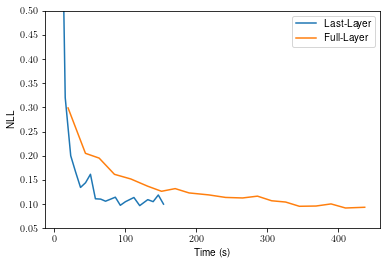

In [32]:
fig, axs = plt.subplots()
axs.plot(ll_tracking["Epoch time"].cumsum(), ll_tracking["NLL"], label="Last-Layer")
axs.plot(full_vi_tracking["Epoch time"].cumsum(), full_vi_tracking["NLL"], label="Full-Layer")
axs.legend()
axs.set_xlabel("Time (s)")
axs.set_ylabel("NLL")
axs.set_ylim(0.05, 0.5)
plt.savefig("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/presentations/presentation_11_1/images/Classification/LLvsFull.jpg")

### MSE vs Epoch

(0.0, 0.25)

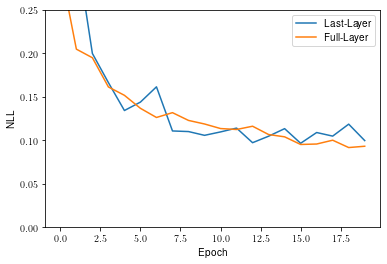

In [16]:
fig, axs = plt.subplots()
axs.plot(list(range(len(ll_tracking))), ll_tracking["NLL"], label="Last-Layer")
axs.plot(list(range(len(full_vi_tracking))), full_vi_tracking["NLL"], label="Full-Layer")
axs.legend()
axs.set_xlabel("Epoch")
axs.set_ylabel("NLL")
axs.set_ylim(0, 0.25)